<a href="https://colab.research.google.com/github/Mainakdas93/Predicting-Future-Alberta-Energy-Consumption-using-LSTM/blob/main/Predicting_Future_Alberta_Energy_Consumption_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis and Visualizations and Predicting Future Alberta Energy Consumption using LSTM**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") # hide warnings

In [2]:
df = pd.read_csv('Alberta Hourly Pool Price and Market Demand(MW).csv')
print("="*50)
print("First Five Rows ","\n")
print(df.head(),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

       Date (HE)  Price ($)  30Ravg ($)  AIL Demand (MW)
0  01/01/2000 01      21.65       40.12             5700
1  01/01/2000 02      21.00       40.12             5555
2  01/01/2000 03       5.90       40.10             5440
3  01/01/2000 04       5.85       40.08             5318
4  01/01/2000 05       5.84       40.05             5276 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date (HE)        210384 non-null  object 
 1   Price ($)        210384 non-null  float64
 2   30Ravg ($)       210384 non-null  float64
 3   AIL Demand (MW)  210384 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.4+ MB
None 

Describe the Dataset  

           Price ($)     30Ravg ($)  AIL Demand (MW)
count  210384.000000  210384.000000    210384.000000
mean       69.4436

# **Exploratory Data Analysis: Reformatting the DateTime Columns**

In [ ]:
#Function to add leading zeroes to a string value if it is single digit otherwise keep it as it is

def add_leading_zero(value):
    return value.zfill(2)

In [3]:
df['Date (HE)'] = df['Date (HE)'].astype(str)
df[['Date', 'Hour']] = df['Date (HE)'].str.split(n=1, expand=True)
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df = df.dropna(subset=['Hour'])
df['Hour'] = df['Hour'].astype(int)
df['Hour']-=1
df[['Minute','Second']] = 0
df['Hour'] = df['Hour'].astype(str)
df['Minute'] = df['Minute'].astype(str)
df['Second'] = df['Second'].astype(str)
df['Hour'] = df['Hour'].apply(add_leading_zero)
df['Minute'] = df['Minute'].apply(add_leading_zero)
df['Second'] = df['Second'].apply(add_leading_zero)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour']+':'+df['Minute']+':'+df['Second'], format='%m/%d/%Y %H:%M:%S')
df.head()

,Date (HE),Price ($),30Ravg ($),AIL Demand (MW),Date,Hour
0,01/01/2000 01,21.65,40.12,5700,01/01/2000,01
1,01/01/2000 02,21.00,40.12,5555,01/01/2000,02
2,01/01/2000 03,5.90,40.10,5440,01/01/2000,03
3,01/01/2000 04,5.85,40.08,5318,01/01/2000,04
4,01/01/2000 05,5.84,40.05,5276,01/01/2000,05


In [11]:
dataset = df[['Datetime','AIL Demand (MW)']]
dataset=dataset.rename(columns={'AIL Demand (MW)': 'AEP_MW'})
dataset["Month"] = pd.to_datetime(dataset["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(dataset["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(dataset["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(dataset["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(dataset["Datetime"]).dt.week
dataset["Day"] = pd.to_datetime(dataset["Datetime"]).dt.day_name()
dataset = dataset.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(10)

,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2000-01-01 00:00:00,5700,1,2000,2000-01-01,00:00:00,52,Saturday
2000-01-01 01:00:00,5555,1,2000,2000-01-01,01:00:00,52,Saturday
2000-01-01 02:00:00,5440,1,2000,2000-01-01,02:00:00,52,Saturday
2000-01-01 03:00:00,5318,1,2000,2000-01-01,03:00:00,52,Saturday
2000-01-01 04:00:00,5276,1,2000,2000-01-01,04:00:00,52,Saturday
2000-01-01 05:00:00,5269,1,2000,2000-01-01,05:00:00,52,Saturday
2000-01-01 06:00:00,5298,1,2000,2000-01-01,06:00:00,52,Saturday
2000-01-01 07:00:00,5399,1,2000,2000-01-01,07:00:00,52,Saturday
2000-01-01 08:00:00,5501,1,2000,2000-01-01,08:00:00,52,Saturday


In [12]:
# How many Unique Year do we Have in Dataset
print(dataset.Year.unique(),"\n")
print("Total Number of Unique Year", dataset.Year.nunique(), "\n")

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023] 

Total Number of Unique Year 24 



# **Vizualizing the Energy Consumption every Year**

Text(0.5, 1.0, 'Energy Consumption According to Year')

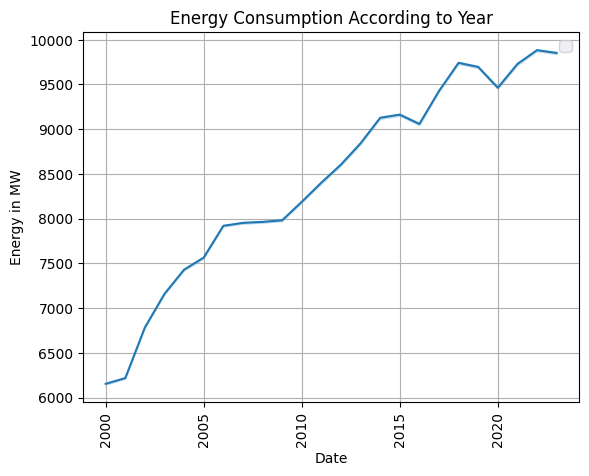

In [13]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.lineplot(x=dataset["Year"], y=dataset["AEP_MW"], data=dataset)
sns.set(rc={'figure.figsize':(20,10)})

plt.title("Energy consumptionnin Year 2004")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

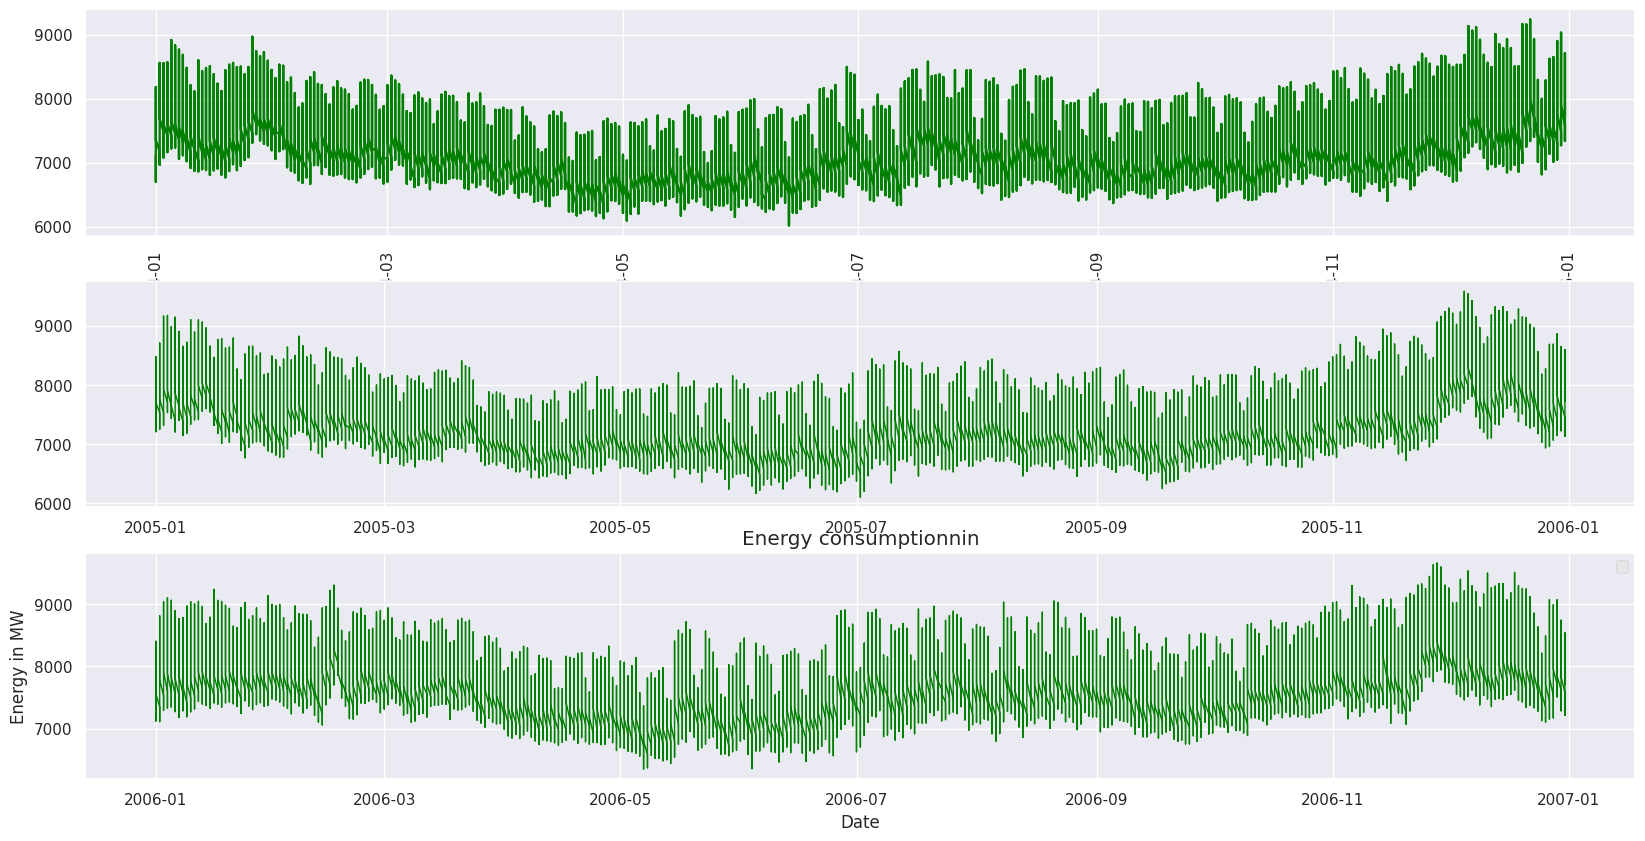

In [14]:
from matplotlib import style


fig = plt.figure()

ax1= fig.add_subplot(311)
ax2= fig.add_subplot(312)
ax3= fig.add_subplot(313)


style.use('ggplot')

y_2004 = dataset.loc["2004"]["AEP_MW"].to_list()
x_2004 = dataset.loc["2004"]["Date"].to_list()
ax1.plot(x_2004,y_2004, color="green", linewidth=1.7)


y_2005 = dataset.loc["2005"]["AEP_MW"].to_list()
x_2005 = dataset.loc["2005"]["Date"].to_list()
ax2.plot(x_2005, y_2005, color="green", linewidth=1)


y_2006 = dataset.loc["2006"]["AEP_MW"].to_list()
x_2006 = dataset.loc["2006"]["Date"].to_list()
ax3.plot(x_2006, y_2006, color="green", linewidth=1)


plt.rcParams["figure.figsize"] = (20,10)
plt.title("Energy consumptionnin")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

# **Energy Distribution Plot**

Text(0.5, 1.0, 'Energy Distribution')

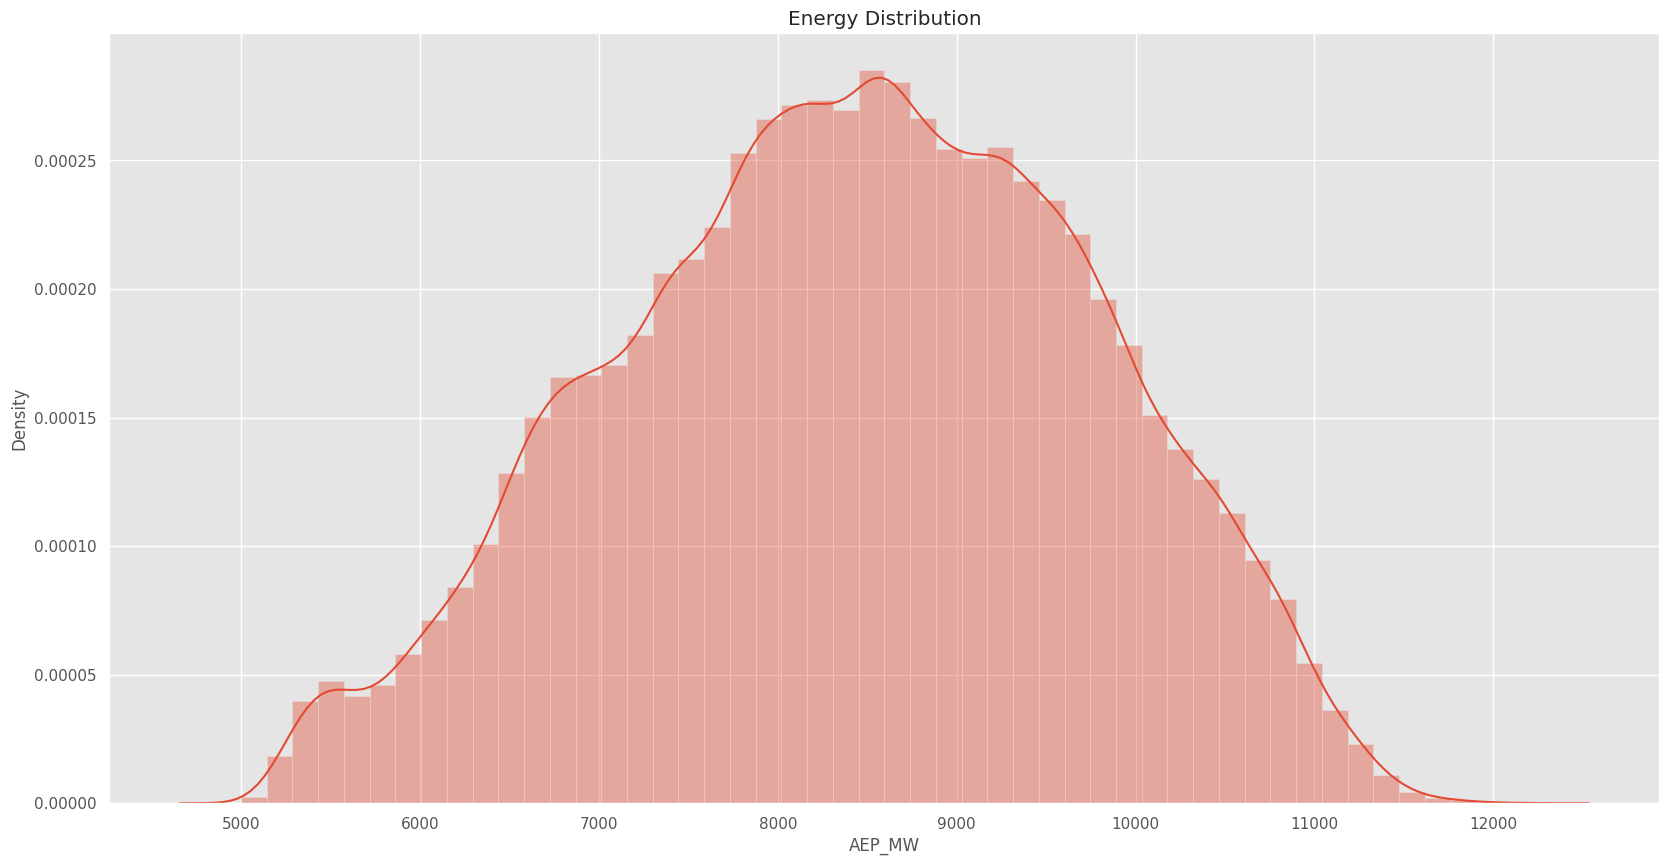

In [15]:
sns.distplot(dataset["AEP_MW"])
plt.title("Energy Distribution")

# **Plotting Energy with Respect to Time**

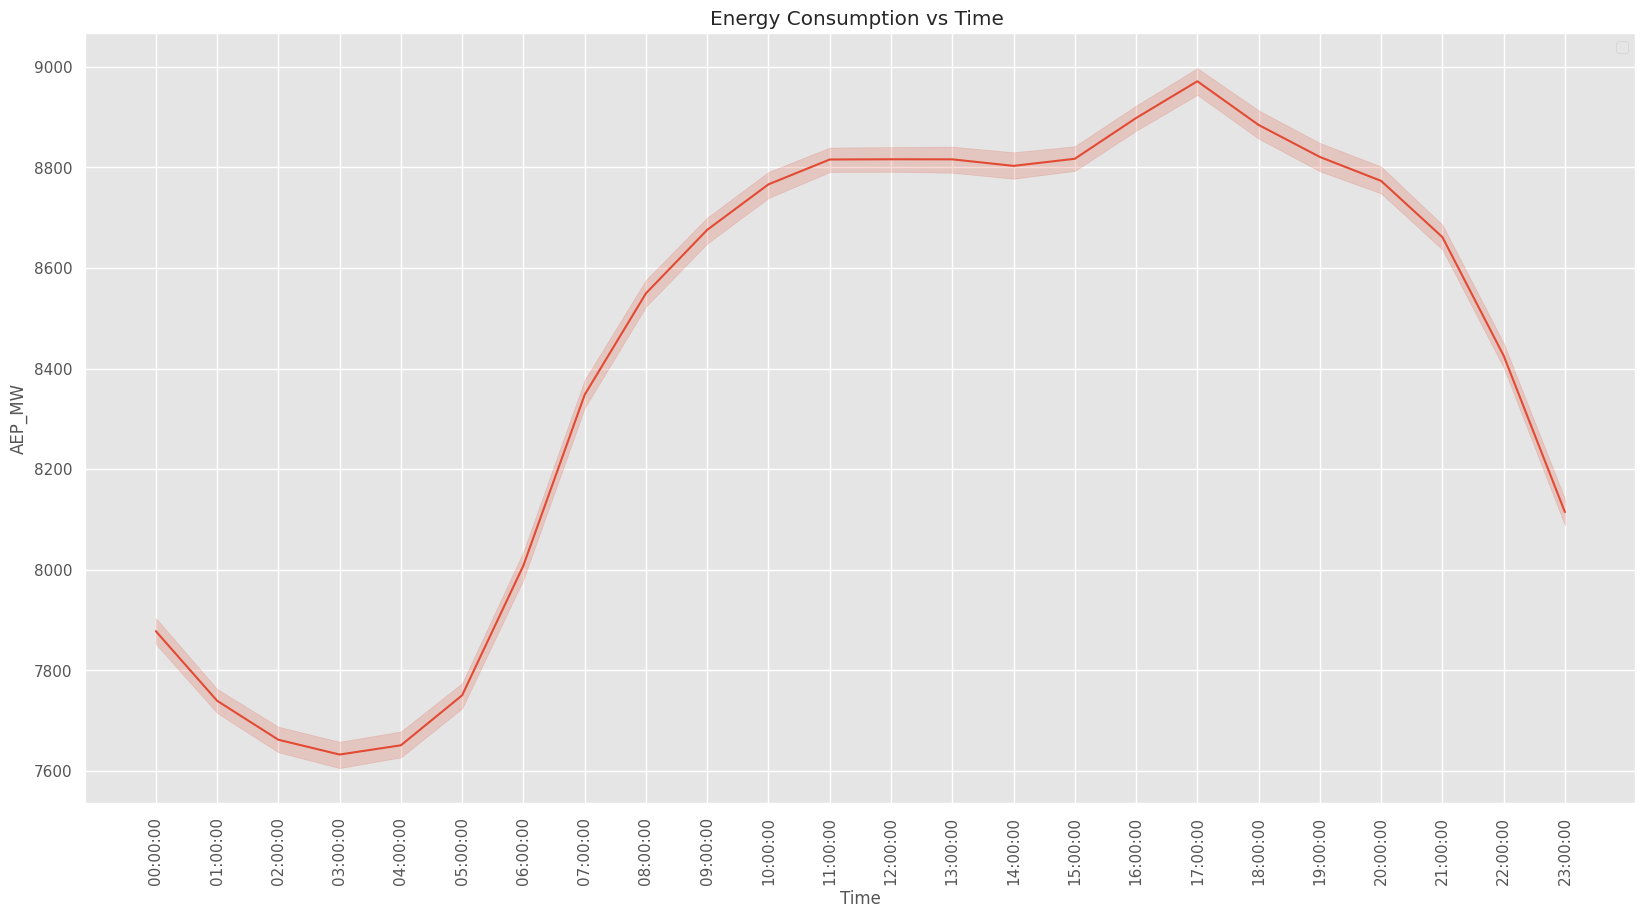

In [16]:
# print(dataset)
fig = plt.figure()
ax1= fig.add_subplot(111)

sns.lineplot(x = dataset["Time"].astype(str), y = dataset["AEP_MW"], data = dataset)
# sns.relplot(data=df, x="Time", y="AEP_MW", kind="line")
plt.title("Energy Consumption vs Time ")
plt.xlabel("Time")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

## **Resampling the Data and preparing the Train and Test Datasets for the LSTM Model**

In [17]:
NewDataSet = dataset.resample('D').mean()

In [18]:
print("Old Dataset ",dataset.shape )
print("New  Dataset ",NewDataSet.shape)

Old Dataset  (210360, 7)
New  Dataset  (8766, 4)


In [19]:
TestData = NewDataSet.tail(100)
Training_Set = NewDataSet.iloc[:,0:1]
Training_Set = Training_Set[:-60]

TestData,Training_Set,Training_Set

(                  AEP_MW  Month    Year  Week
 Datetime                                     
 2023-09-23   9035.583333    9.0  2023.0  38.0
 2023-09-24   9025.416667    9.0  2023.0  38.0
 2023-09-25   9328.833333    9.0  2023.0  39.0
 2023-09-26   9383.458333    9.0  2023.0  39.0
 2023-09-27   9241.625000    9.0  2023.0  39.0
 ...                  ...    ...     ...   ...
 2023-12-27  10476.250000   12.0  2023.0  52.0
 2023-12-28  10478.583333   12.0  2023.0  52.0
 2023-12-29  10303.583333   12.0  2023.0  52.0
 2023-12-30  10329.041667   12.0  2023.0  52.0
 2023-12-31  10132.708333   12.0  2023.0  52.0
 
 [100 rows x 4 columns],
                   AEP_MW
 Datetime                
 2000-01-01   5805.708333
 2000-01-02   5994.125000
 2000-01-03   6405.416667
 2000-01-04   6424.916667
 2000-01-05   6372.083333
 ...                  ...
 2023-10-28   9938.458333
 2023-10-29   9778.750000
 2023-10-30  10095.833333
 2023-10-31  10020.833333
 2023-11-01  10062.791667
 
 [8706 rows x 1 column

In [20]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (8706, 1)
Test Set Shape  (100, 4)


In [21]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)
Train

array([[0.05590305],
       [0.08691686],
       [0.15461641],
       ...,
       [0.7620674 ],
       [0.74972223],
       [0.75662867]])

In [22]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END
for i in range(60, Train.shape[0]):

    # X_Train 0-59
    X_Train.append(Train[i-60:i])

    # Y Would be 60 th Value based on past 60 Values
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(8646, 60, 1)
(8646, 1)


In [23]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(8646, 60, 1)

# **LSTM Model**

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [25]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
271/271 [==============================] - 30s 90ms/step - loss: 0.0093
Epoch 2/50
271/271 [==============================] - 23s 84ms/step - loss: 0.0046
Epoch 3/50
271/271 [==============================] - 20s 74ms/step - loss: 0.0040
Epoch 4/50
271/271 [==============================] - 22s 80ms/step - loss: 0.0038
Epoch 5/50
271/271 [==============================] - 21s 77ms/step - loss: 0.0035
Epoch 6/50
271/271 [==============================] - 26s 95ms/step - loss: 0.0031
Epoch 7/50
271/271 [==============================] - 25s 91ms/step - loss: 0.0030
Epoch 8/50
271/271 [==============================] - 23s 86ms/step - loss: 0.0029
Epoch 9/50
271/271 [==============================] - 22s 82ms/step - loss: 0.0028
Epoch 10/50
271/271 [==============================] - 24s 87ms/step - loss: 0.0025
Epoch 11/50
271/271 [==============================] - 28s 103ms/step - loss: 0.0025
Epoch 12/50
271/271 [==============================] - 20s 74ms/step - loss: 0.0025


# **Test Data**

In [26]:
TestData.head(5)

,AEP_MW,Month,Year,Week
Datetime,,,,
2023-09-23,9035.583333,9.0,2023.0,38.0
2023-09-24,9025.416667,9.0,2023.0,38.0
2023-09-25,9328.833333,9.0,2023.0,39.0
2023-09-26,9383.458333,9.0,2023.0,39.0
2023-09-27,9241.625000,9.0,2023.0,39.0


In [27]:
TestData.shape

(100, 4)

In [28]:
NewDataSet.shape

(8766, 4)

In [29]:
Df_Total = pd.concat((NewDataSet[['AEP_MW']],TestData[['AEP_MW']]), axis=0)

In [30]:
Df_Total.shape

(8866, 1)

In [31]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# We need to Reshape
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])

# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model
predicted_consumption = regressor.predict(X_test)

# Do inverse Transformation to get Values
predicted_consumption = sc.inverse_transform(predicted_consumption)
predicted_consumption.shape

4/4 [==============================] - 1s 19ms/step


(100, 1)

# **Predicted Future Alberta Energy Consumption**

In [32]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = predicted_consumption
dates = TestData.index.to_list()

In [33]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueMegaWatt": True_MegaWatt,
    "PredictedMegaWatt":[x[0] for x in Predicted_MegaWatt ]
})

In [34]:
Machine_Df

,Date,TrueMegaWatt,PredictedMegaWatt
0,2023-09-23,9035.583333,10284.826172
1,2023-09-24,9025.416667,9375.992188
2,2023-09-25,9328.833333,9437.961914
3,2023-09-26,9383.458333,9548.719727
4,2023-09-27,9241.625000,9542.544922
...,...,...,...
95,2023-12-27,10476.250000,10282.125977
96,2023-12-28,10478.583333,10538.856445
97,2023-12-29,10303.583333,10473.781250
98,2023-12-30,10329.041667,10235.691406


In [35]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = [x[0] for x in Predicted_MegaWatt ]
dates = TestData.index.to_list()

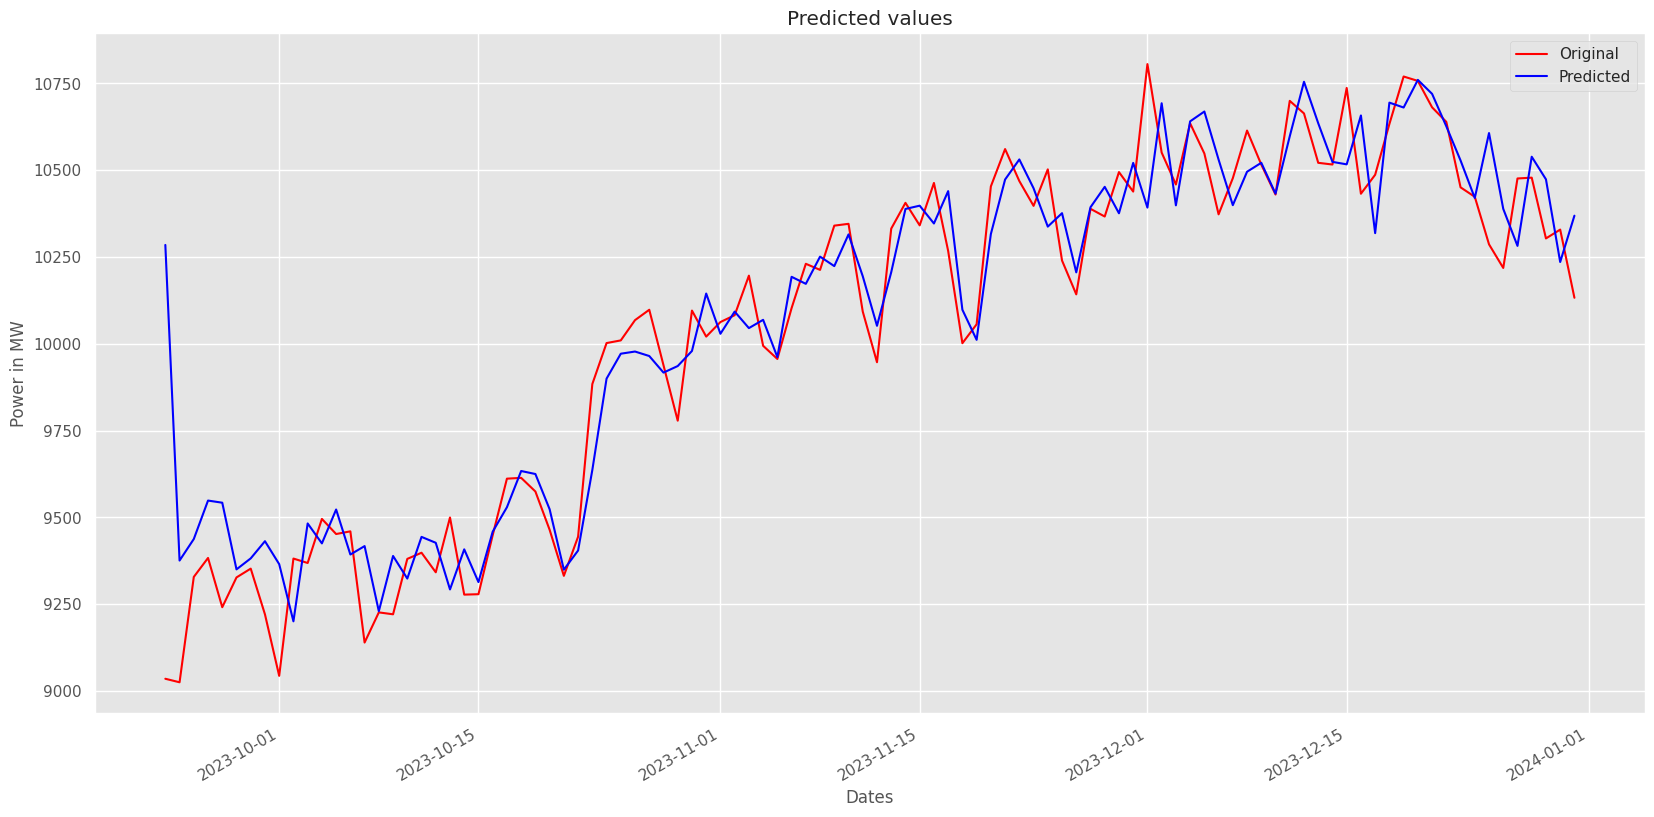

In [36]:
fig = plt.figure()
ax1= fig.add_subplot(111)
x = dates
y = True_MegaWatt
y1 = Predicted_MegaWatt
plt.plot(x,y, color="red", label = "Original")
plt.plot(x,y1, color="blue", label = "Predicted")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Predicted values")

plt.legend()